In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
import art
import asyncio
from dotenv import load_dotenv
import json
import openai
import random
import re
from typing import TypedDict

load_dotenv()


class TemporalCluePuzzle(TypedDict):
    num_clues: int
    prompt: str
    solution: dict[str, str]


puzzles: list[TemporalCluePuzzle] = json.load(open("./data/temporal-clue/puzzles.json"))
val_puzzles = puzzles[:64]
test_puzzles = puzzles[64:128]
train_puzzles = puzzles[128:]
random.seed(42)
random.shuffle(train_puzzles)

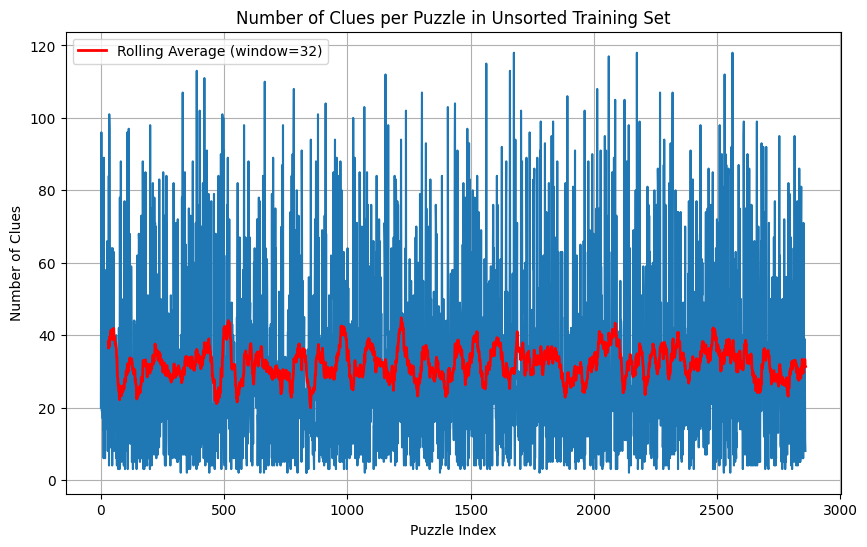

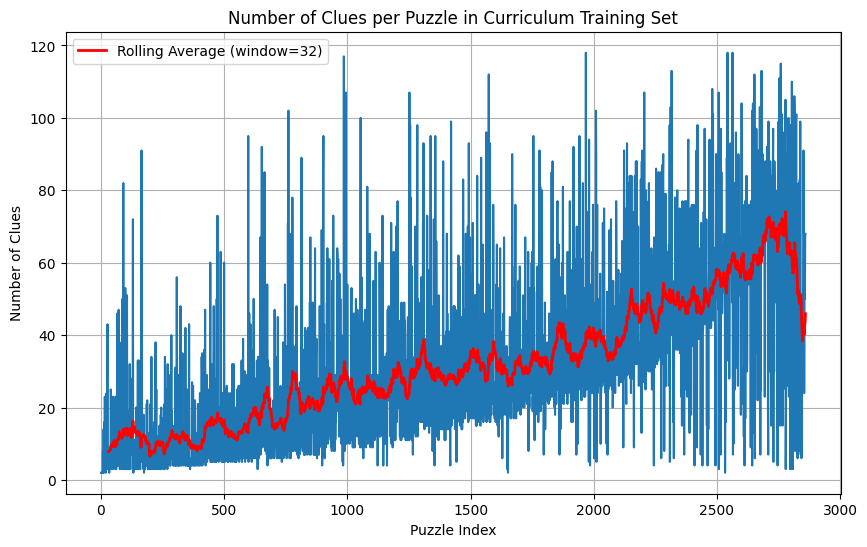

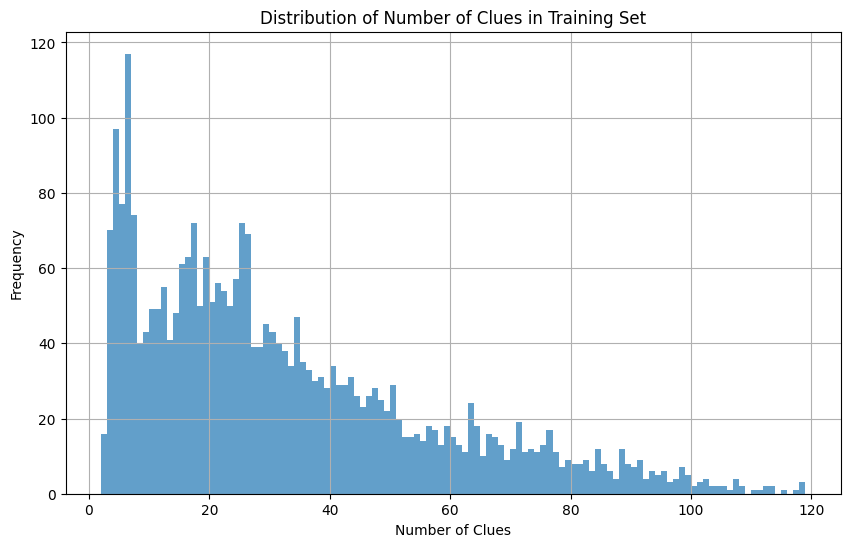

In [4]:
import matplotlib.pyplot as plt
import numpy as np

min_clues = min(x["num_clues"] for x in train_puzzles)
max_clues = max(x["num_clues"] for x in train_puzzles)

# Plot the unsorted training puzzle clues
plt.figure(figsize=(10, 6))
unsorted_clues = [puzzle["num_clues"] for puzzle in train_puzzles]
plt.plot(range(len(train_puzzles)), unsorted_clues)

# Calculate and plot rolling average
window_size = 32
rolling_avg = np.convolve(
    unsorted_clues, np.ones(window_size) / window_size, mode="valid"
)
plt.plot(
    range(window_size - 1, len(unsorted_clues)),
    rolling_avg,
    "r-",
    linewidth=2,
    label=f"Rolling Average (window={window_size})",
)

plt.xlabel("Puzzle Index")
plt.ylabel("Number of Clues")
plt.title("Number of Clues per Puzzle in Unsorted Training Set")
plt.legend()
plt.grid(True)
plt.show()

curriculum_train_puzzles = sorted(
    train_puzzles,
    key=lambda x: ((x["num_clues"] - min_clues) / (max_clues - min_clues))
    * random.random()
    + random.random() ** 30,
)

# Plot the number of clues for each puzzle in the training set
plt.figure(figsize=(10, 6))
clues = [puzzle["num_clues"] for puzzle in curriculum_train_puzzles]
plt.plot(range(len(curriculum_train_puzzles)), clues)

# Calculate and plot rolling average
window_size = 32
rolling_avg = np.convolve(clues, np.ones(window_size) / window_size, mode="valid")
plt.plot(
    range(window_size - 1, len(clues)),
    rolling_avg,
    "r-",
    linewidth=2,
    label=f"Rolling Average (window={window_size})",
)

plt.xlabel("Puzzle Index")
plt.ylabel("Number of Clues")
plt.title("Number of Clues per Puzzle in Curriculum Training Set")
plt.legend()
plt.grid(True)
plt.show()

# Plot the distribution of clues
plt.figure(figsize=(10, 6))
plt.hist(clues, bins=range(min(clues), max(clues) + 2), alpha=0.7)
plt.xlabel("Number of Clues")
plt.ylabel("Frequency")
plt.title("Distribution of Number of Clues in Training Set")
plt.grid(True)
plt.show()

$ vllm serve NousResearch/Hermes-2-Theta-Llama-3-8B --block-size=32 --disable-log-requests --enable-chunked-prefill --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-num-seqs=2048 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --tool-call-parser=hermes --served-model-name=temporal-clue-005 --port=8000 --api-key=default
INFO 03-17 15:37:41 __init__.py:207] Automatically detected platform cuda.
INFO 03-17 15:37:41 api_server.py:912] vLLM API server version 0.7.3
INFO 03-17 15:37:41 api_server.py:913] args: Namespace(subparser='serve', model_tag='NousResearch/Hermes-2-Theta-Llama-3-8B', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', response_rol

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:01<00:03,  1.11s/it]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.49it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.16it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.06it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.10it/s]



INFO 03-17 15:38:21 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 03-17 15:38:23 worker.py:267] Memory profiling takes 1.29 seconds
INFO 03-17 15:38:23 worker.py:267] the current vLLM instance can use total_gpu_memory (79.19GiB) x gpu_memory_utilization (0.95) = 75.23GiB
INFO 03-17 15:38:23 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 9.45GiB; the rest of the memory reserved for KV Cache is 50.67GiB.
INFO 03-17 15:38:23 executor_base.py:111] # cuda blocks: 12972, # CPU blocks: 20480
INFO 03-17 15:38:23 executor_base.py:116] Maximum concurrency for 8192 tokens per request: 50.67x
INFO 03-17 15:39:16 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 54.66 seconds
INFO 03-17 15:39:17 api_server.py:958] Starting vLLM API server on http://0.0.0.0:8000
INFO 03-17 15:39:17 launcher.py:23] Available routes are:
INFO 03-17 15:39:17 launcher.py:31] Route: /openapi.json, Methods: HEAD

INFO:     Started server process [6231]
INFO:     Waiting for application startup.
INFO:     Application startup complete.


INFO 03-17 15:39:20 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:45324 - "POST /v1/chat/completions HTTP/1.1" 200 OK


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


wandb: Currently logged in as: bradhilton to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


"train/completion_tokens" not found in run history


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

No "val/reward" metric found in history


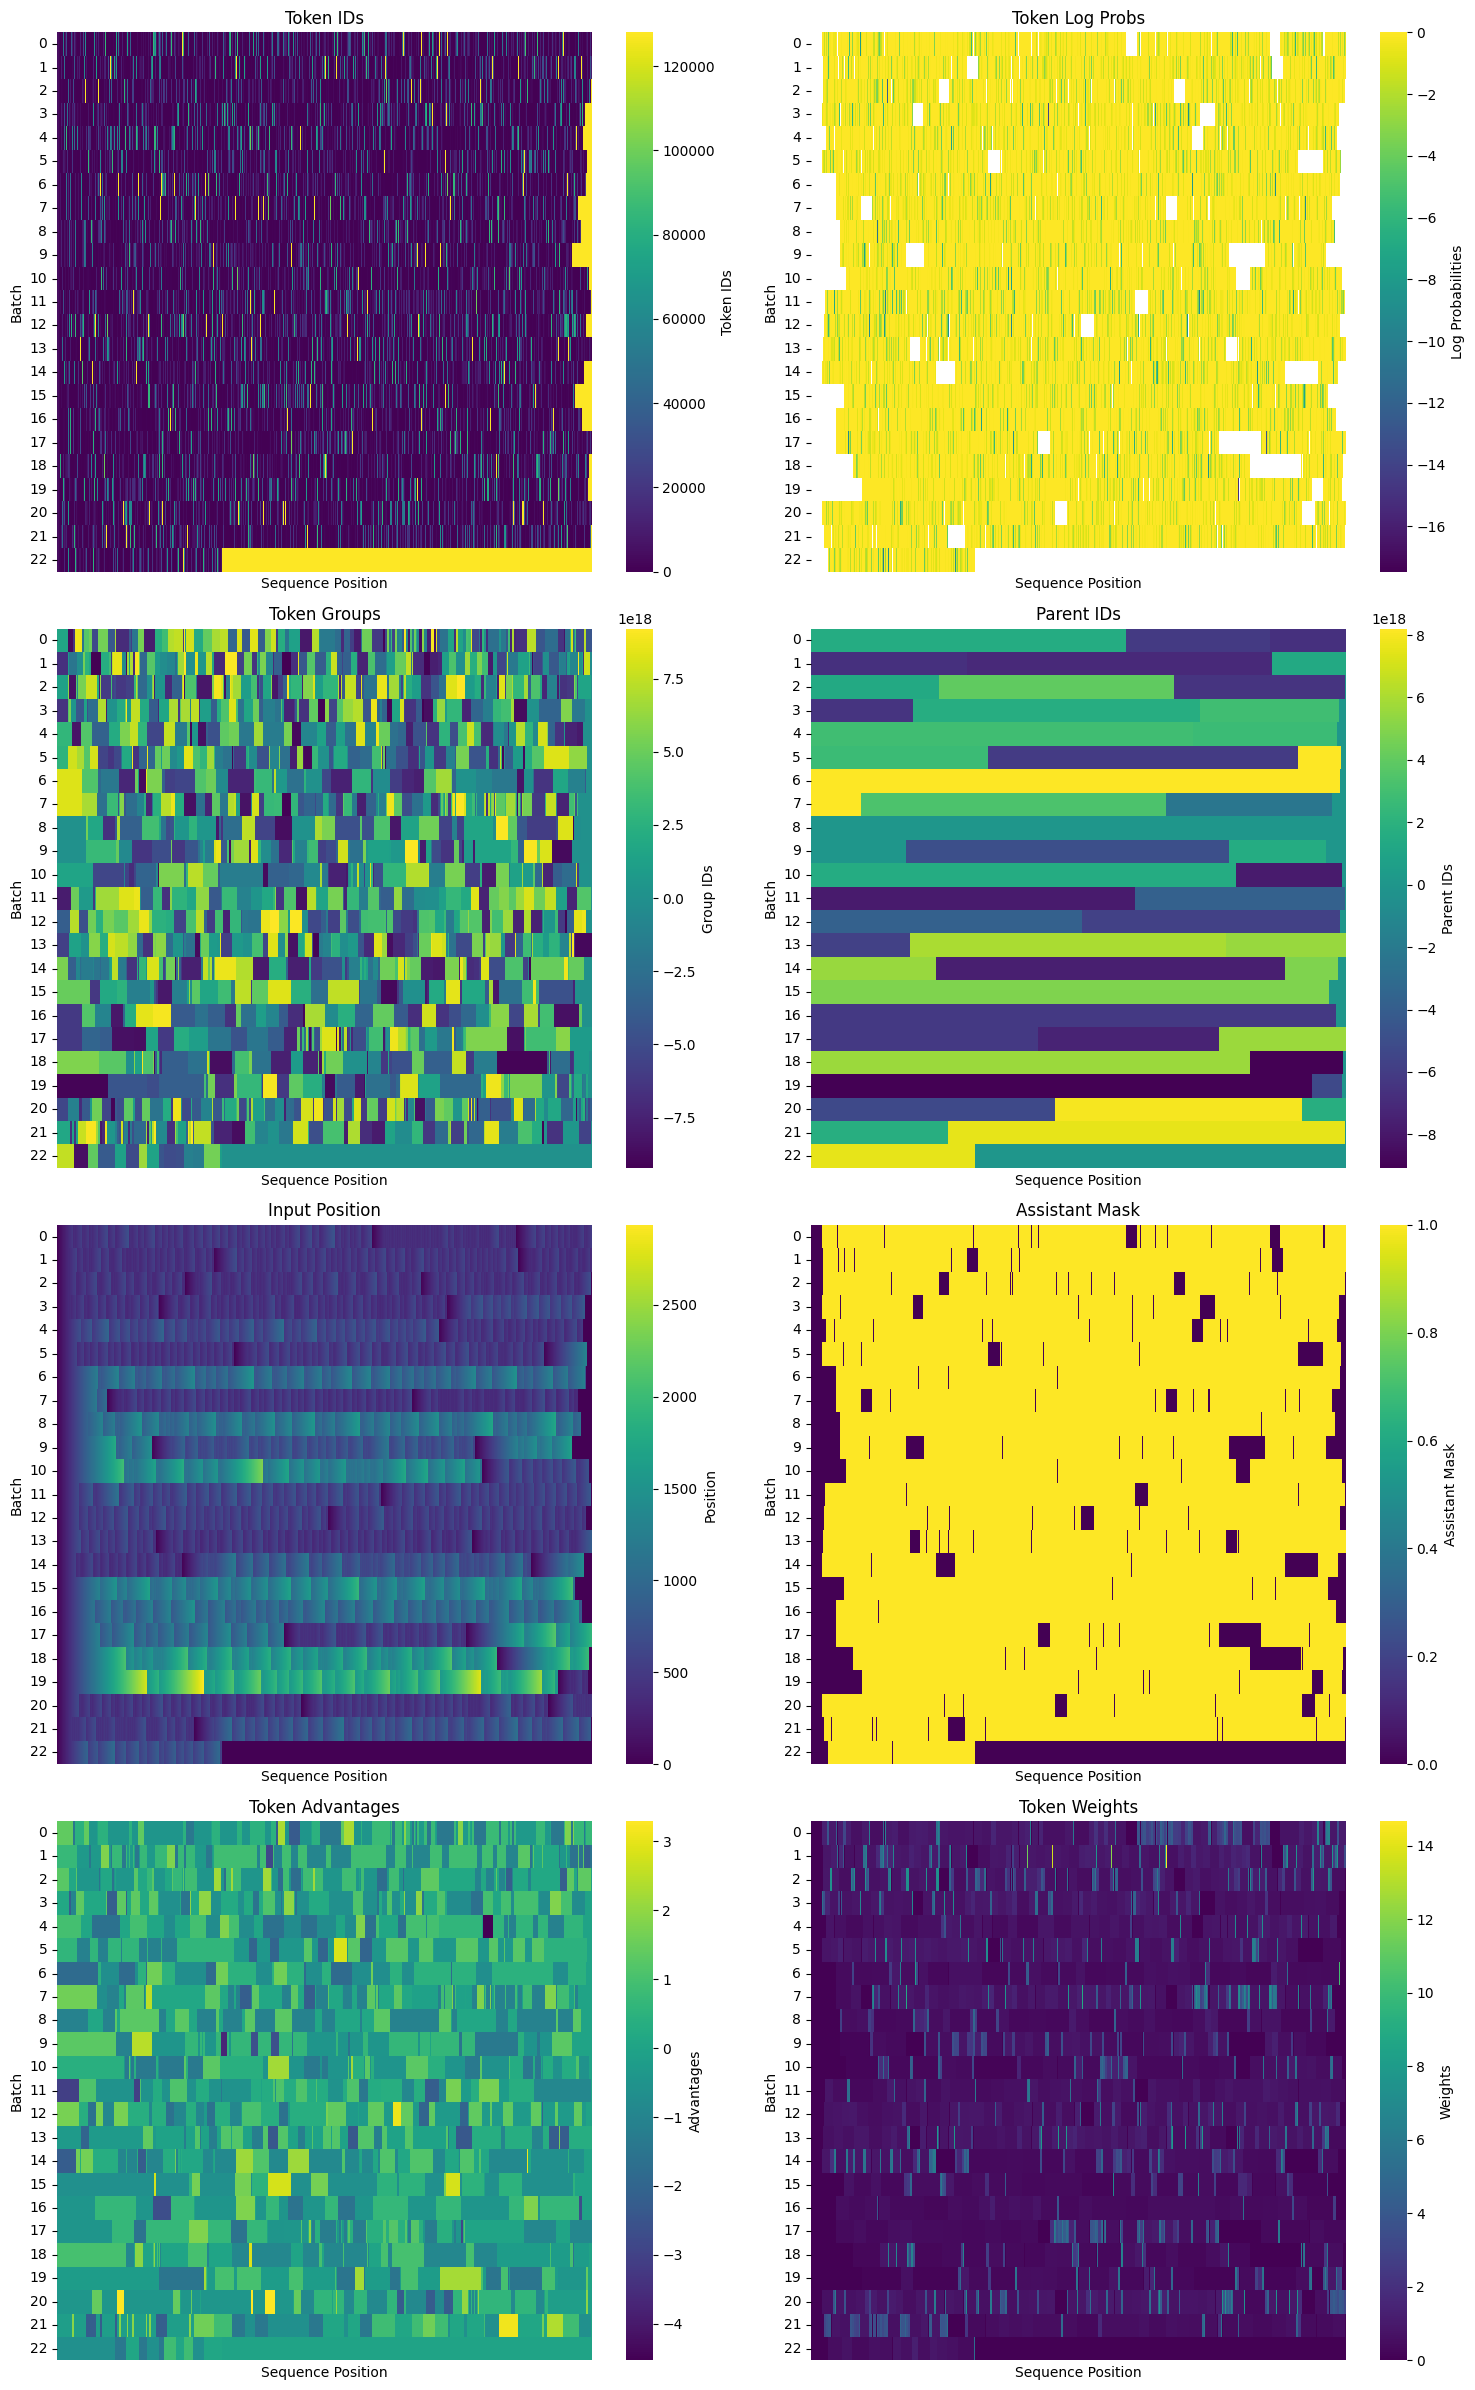

Download complete. Moving file to /home/ubuntu/.cache/huggingface/hub/models--NousResearch--Hermes-2-Theta-Llama-3-8B/blobs/15a75279e8911d4c1f515986546f6fcb5ad0717c
Download complete. Moving file to /home/ubuntu/.cache/huggingface/hub/models--NousResearch--Hermes-2-Theta-Llama-3-8B/blobs/65efd9e0e3baa04473b66aa4ad473e9302cf7fc6
$ tune run art.local.recipe.TuneRecipe --config ./.art/models/temporal-clue-005/config.yaml


<frozen runpy>:128: RuntimeWarning: 'art.local.recipe' found in sys.modules after import of package 'art.local', but prior to execution of 'art.local.recipe'; this may result in unpredictable behaviour
DEBUG:torchtune.utils._logging:Training is not distributed. If you want to train on multiple GPUs and are using the tune CLI, specify --nnodes 1 and --nproc_per_node [num_gpus]
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/ubuntu/.cache/huggingface/hub/models--NousResearch--Hermes-2-Theta-Llama-3-8B/snapshots/57a73110702e7b05ba3f39fef36297454c680725
  checkpoint_files:
  - model-00001-of-00004.safetensors
  - model-00004-of-00004.safetensors
  - model-00003-of-00004.safetensors
  - model-00002-of-00004.safetensors
  model_type: LLAMA3
  output_

Writing logs to .art/models/temporal-clue-005/logs/log_1742226078.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 2.49 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 15.02 GiB
	GPU peak memory reserved: 15.14 GiB
	GPU peak memory active: 15.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|11|Loss: 0.0139: 100%|██████████| 11/11 [03:49<00:00, 19.48s/it, loss=0.0139, policy=0.0139, entropy=0.497, kl_div=nan]   INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...

$ vllm serve /home/ubuntu/sky_workdir/examples/.art/models/temporal-clue-005/0001 --block-size=32 --disable-log-requests --enable-chunked-prefill --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-num-seqs=2048 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --tool-call-parser=hermes --served-model-name=temporal-clue-005 --port=8000 --api-key=default
INFO 03-17 15:45:45 __init__.py:207] Automatically detected platform cuda.
INFO 03-17 15:45:45 api_server.py:912] vLLM API server version 0.7.3
INFO 03-17 15:45:45 api_server.py:913] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/examples/.art/models/temporal-clue-005/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_temp

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:00,  4.80it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.63it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.29it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.17it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.31it/s]



INFO 03-17 15:46:01 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 03-17 15:46:03 worker.py:267] Memory profiling takes 1.23 seconds
INFO 03-17 15:46:03 worker.py:267] the current vLLM instance can use total_gpu_memory (79.19GiB) x gpu_memory_utilization (0.95) = 75.23GiB
INFO 03-17 15:46:03 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 9.45GiB; the rest of the memory reserved for KV Cache is 50.67GiB.
INFO 03-17 15:46:03 executor_base.py:111] # cuda blocks: 12972, # CPU blocks: 20480
INFO 03-17 15:46:03 executor_base.py:116] Maximum concurrency for 8192 tokens per request: 50.67x
INFO 03-17 15:46:55 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 54.18 seconds
INFO 03-17 15:46:56 api_server.py:958] Starting vLLM API server on http://0.0.0.0:8000
INFO 03-17 15:46:56 launcher.py:23] Available routes are:
INFO 03-17 15:46:56 launcher.py:31] Route: /openapi.json, Methods: HEAD

INFO:     Started server process [11068]
INFO:     Waiting for application startup.
INFO:     Application startup complete.


INFO 03-17 15:47:04 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 03-17 15:47:04 metrics.py:455] Avg prompt throughput: 1.3 tokens/s, Avg generation throughput: 0.1 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 03-17 15:47:04 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:44616 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log
Using previous iteration 206.2475 completion tokens per request as estimate


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

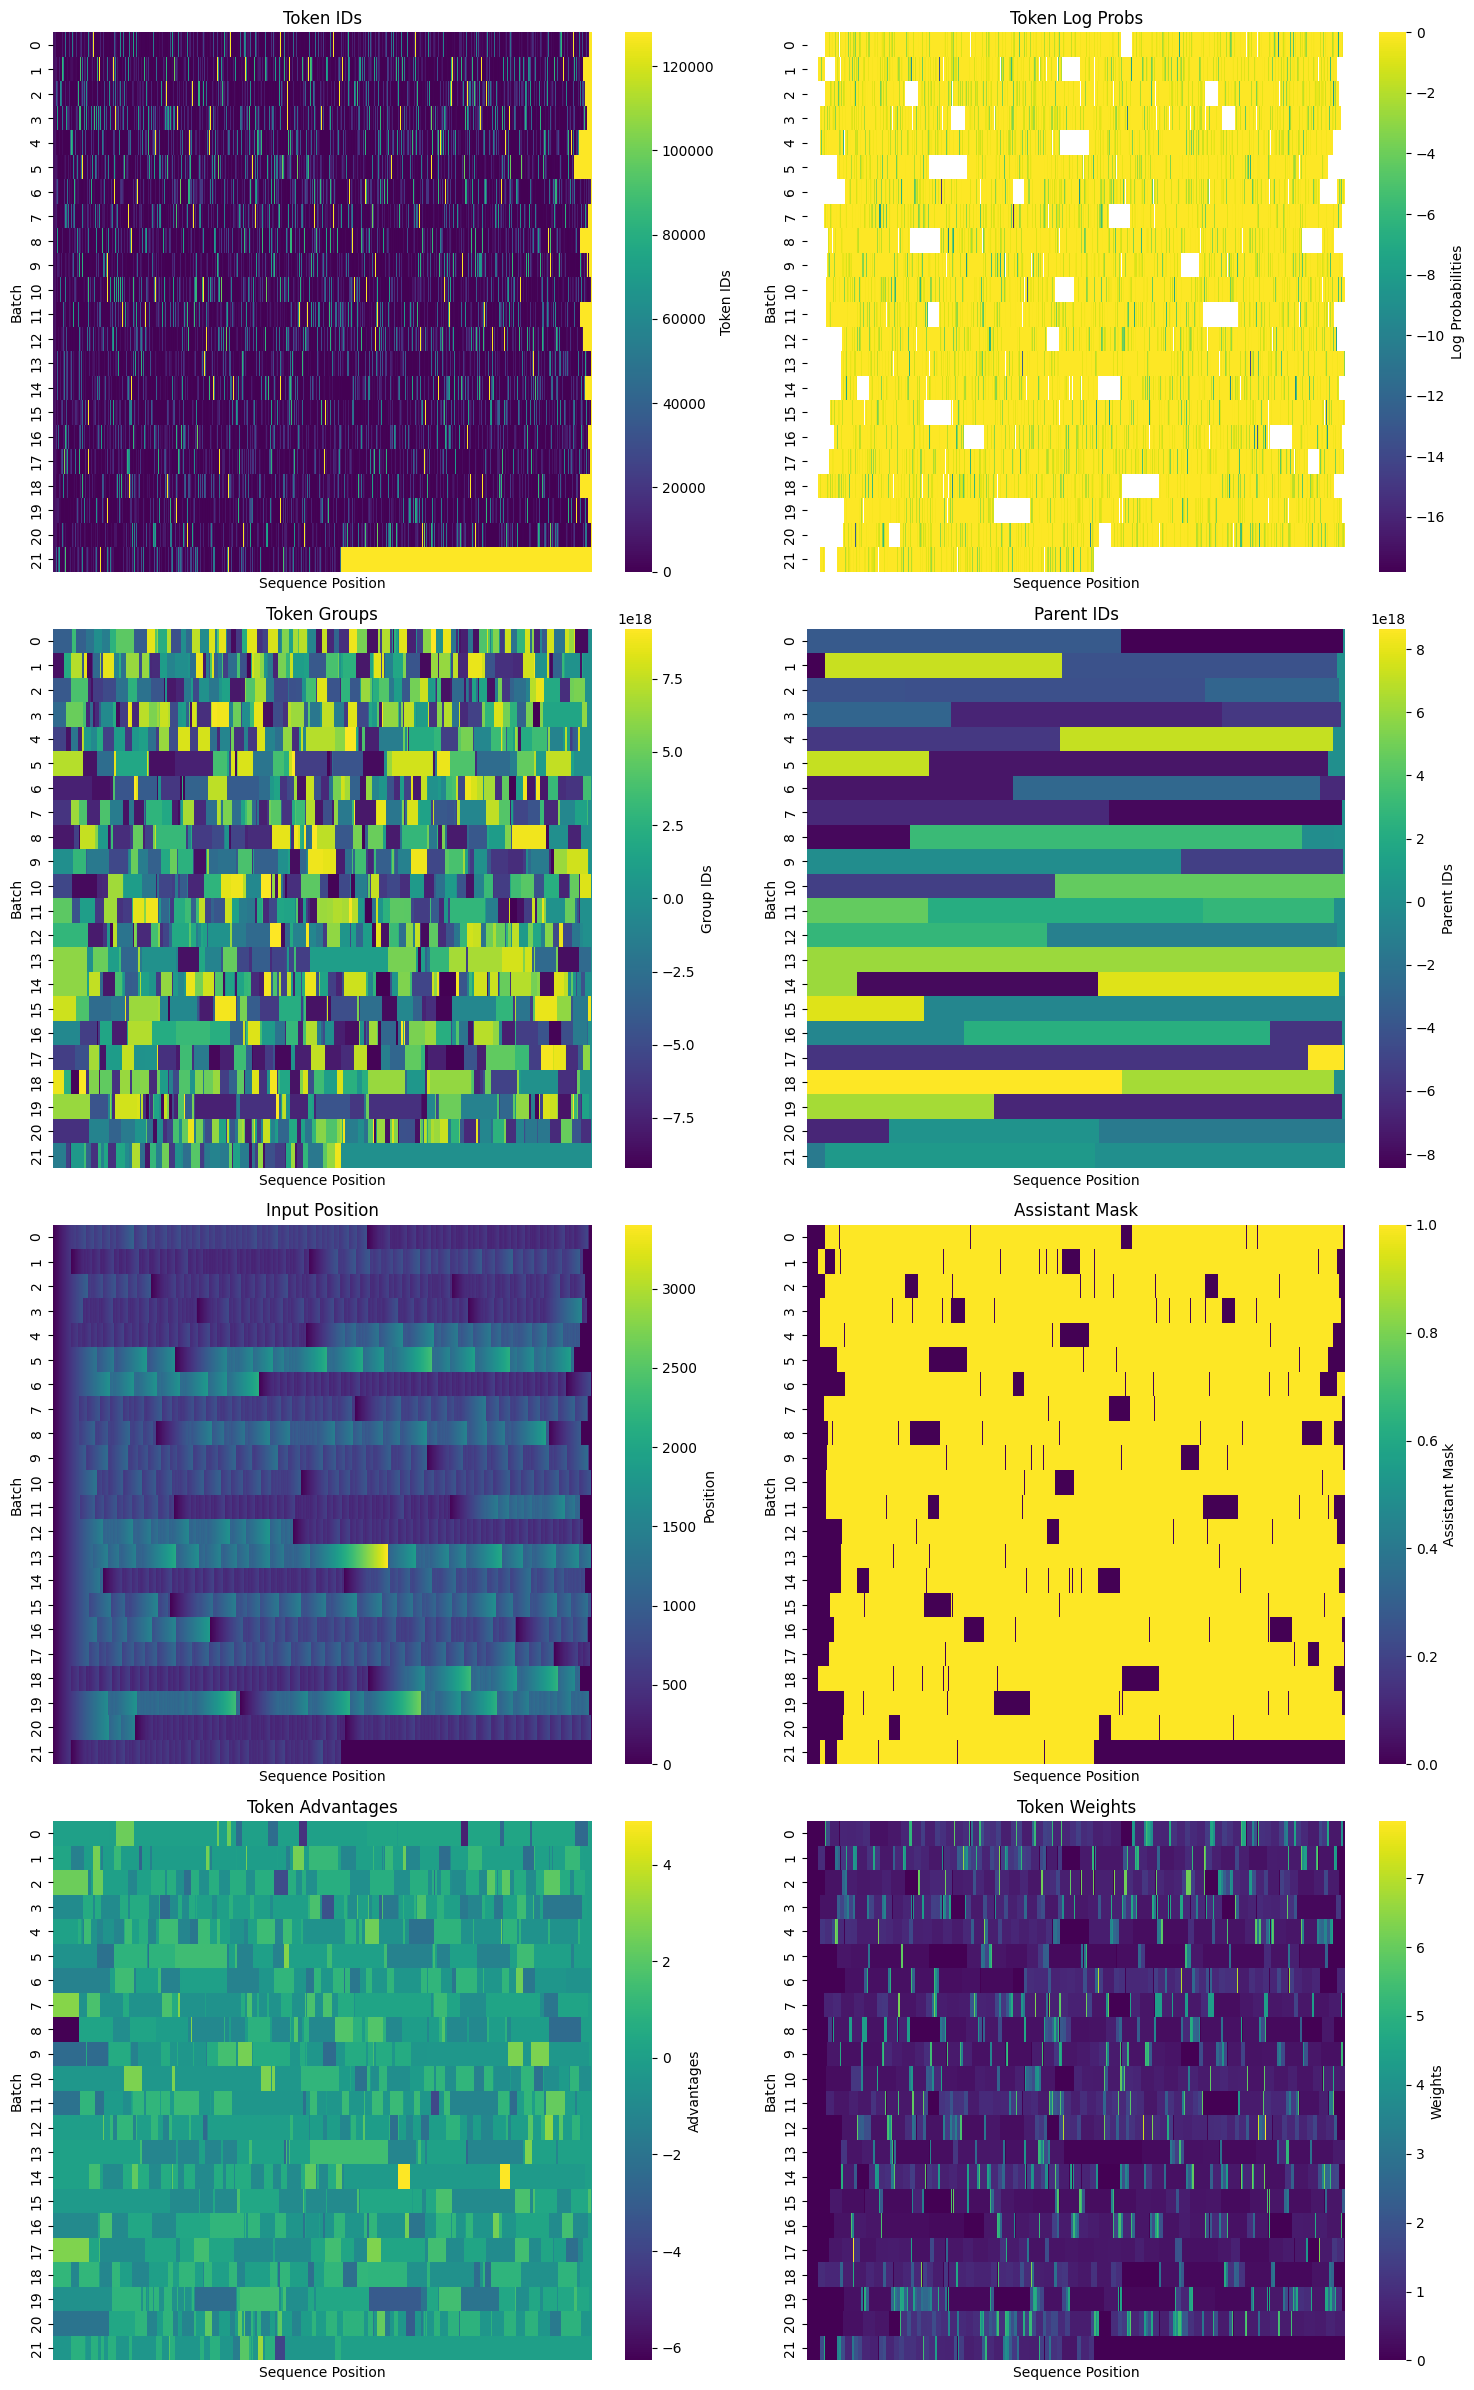

$ tune run art.local.recipe.TuneRecipe --config ./.art/models/temporal-clue-005/config.yaml


<frozen runpy>:128: RuntimeWarning: 'art.local.recipe' found in sys.modules after import of package 'art.local', but prior to execution of 'art.local.recipe'; this may result in unpredictable behaviour
DEBUG:torchtune.utils._logging:Training is not distributed. If you want to train on multiple GPUs and are using the tune CLI, specify --nnodes 1 and --nproc_per_node [num_gpus]
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./.art/models/temporal-clue-005/0001
  checkpoint_files:
  - ft-model-00004-of-00004.safetensors
  - ft-model-00001-of-00004.safetensors
  - ft-model-00003-of-00004.safetensors
  - ft-model-00002-of-00004.safetensors
  model_type: LLAMA3
  output_dir: ./.art/models/temporal-clue-005
  recipe_checkpoint: null
compile: true
custom_sh

Writing logs to .art/models/temporal-clue-005/logs/log_1742226551.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 2.85 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 15.02 GiB
	GPU peak memory reserved: 15.14 GiB
	GPU peak memory active: 15.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|11|Loss: 0.0024: 100%|██████████| 11/11 [03:41<00:00, 19.47s/it, loss=0.00239, policy=0.00239, entropy=0.399, kl_div=nan]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...


$ vllm serve /home/ubuntu/sky_workdir/examples/.art/models/temporal-clue-005/0002 --block-size=32 --disable-log-requests --enable-chunked-prefill --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-num-seqs=2048 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --tool-call-parser=hermes --served-model-name=temporal-clue-005 --port=8000 --api-key=default
INFO 03-17 15:53:31 __init__.py:207] Automatically detected platform cuda.
INFO 03-17 15:53:31 api_server.py:912] vLLM API server version 0.7.3
INFO 03-17 15:53:31 api_server.py:913] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/examples/.art/models/temporal-clue-005/0002', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_temp

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:00,  4.66it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.57it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.22it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.09it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.23it/s]



INFO 03-17 15:53:48 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 03-17 15:53:49 worker.py:267] Memory profiling takes 1.26 seconds
INFO 03-17 15:53:49 worker.py:267] the current vLLM instance can use total_gpu_memory (79.19GiB) x gpu_memory_utilization (0.95) = 75.23GiB
INFO 03-17 15:53:49 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 9.45GiB; the rest of the memory reserved for KV Cache is 50.67GiB.
INFO 03-17 15:53:49 executor_base.py:111] # cuda blocks: 12972, # CPU blocks: 20480
INFO 03-17 15:53:49 executor_base.py:116] Maximum concurrency for 8192 tokens per request: 50.67x
INFO 03-17 15:54:48 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 60.49 seconds
INFO 03-17 15:54:49 api_server.py:958] Starting vLLM API server on http://0.0.0.0:8000
INFO 03-17 15:54:49 launcher.py:23] Available routes are:
INFO 03-17 15:54:49 launcher.py:31] Route: /openapi.json, Methods: HEAD

INFO:     Started server process [14638]
INFO:     Waiting for application startup.
INFO:     Application startup complete.


INFO 03-17 15:54:49 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:59688 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log
Using previous iteration 195.705 completion tokens per request as estimate


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

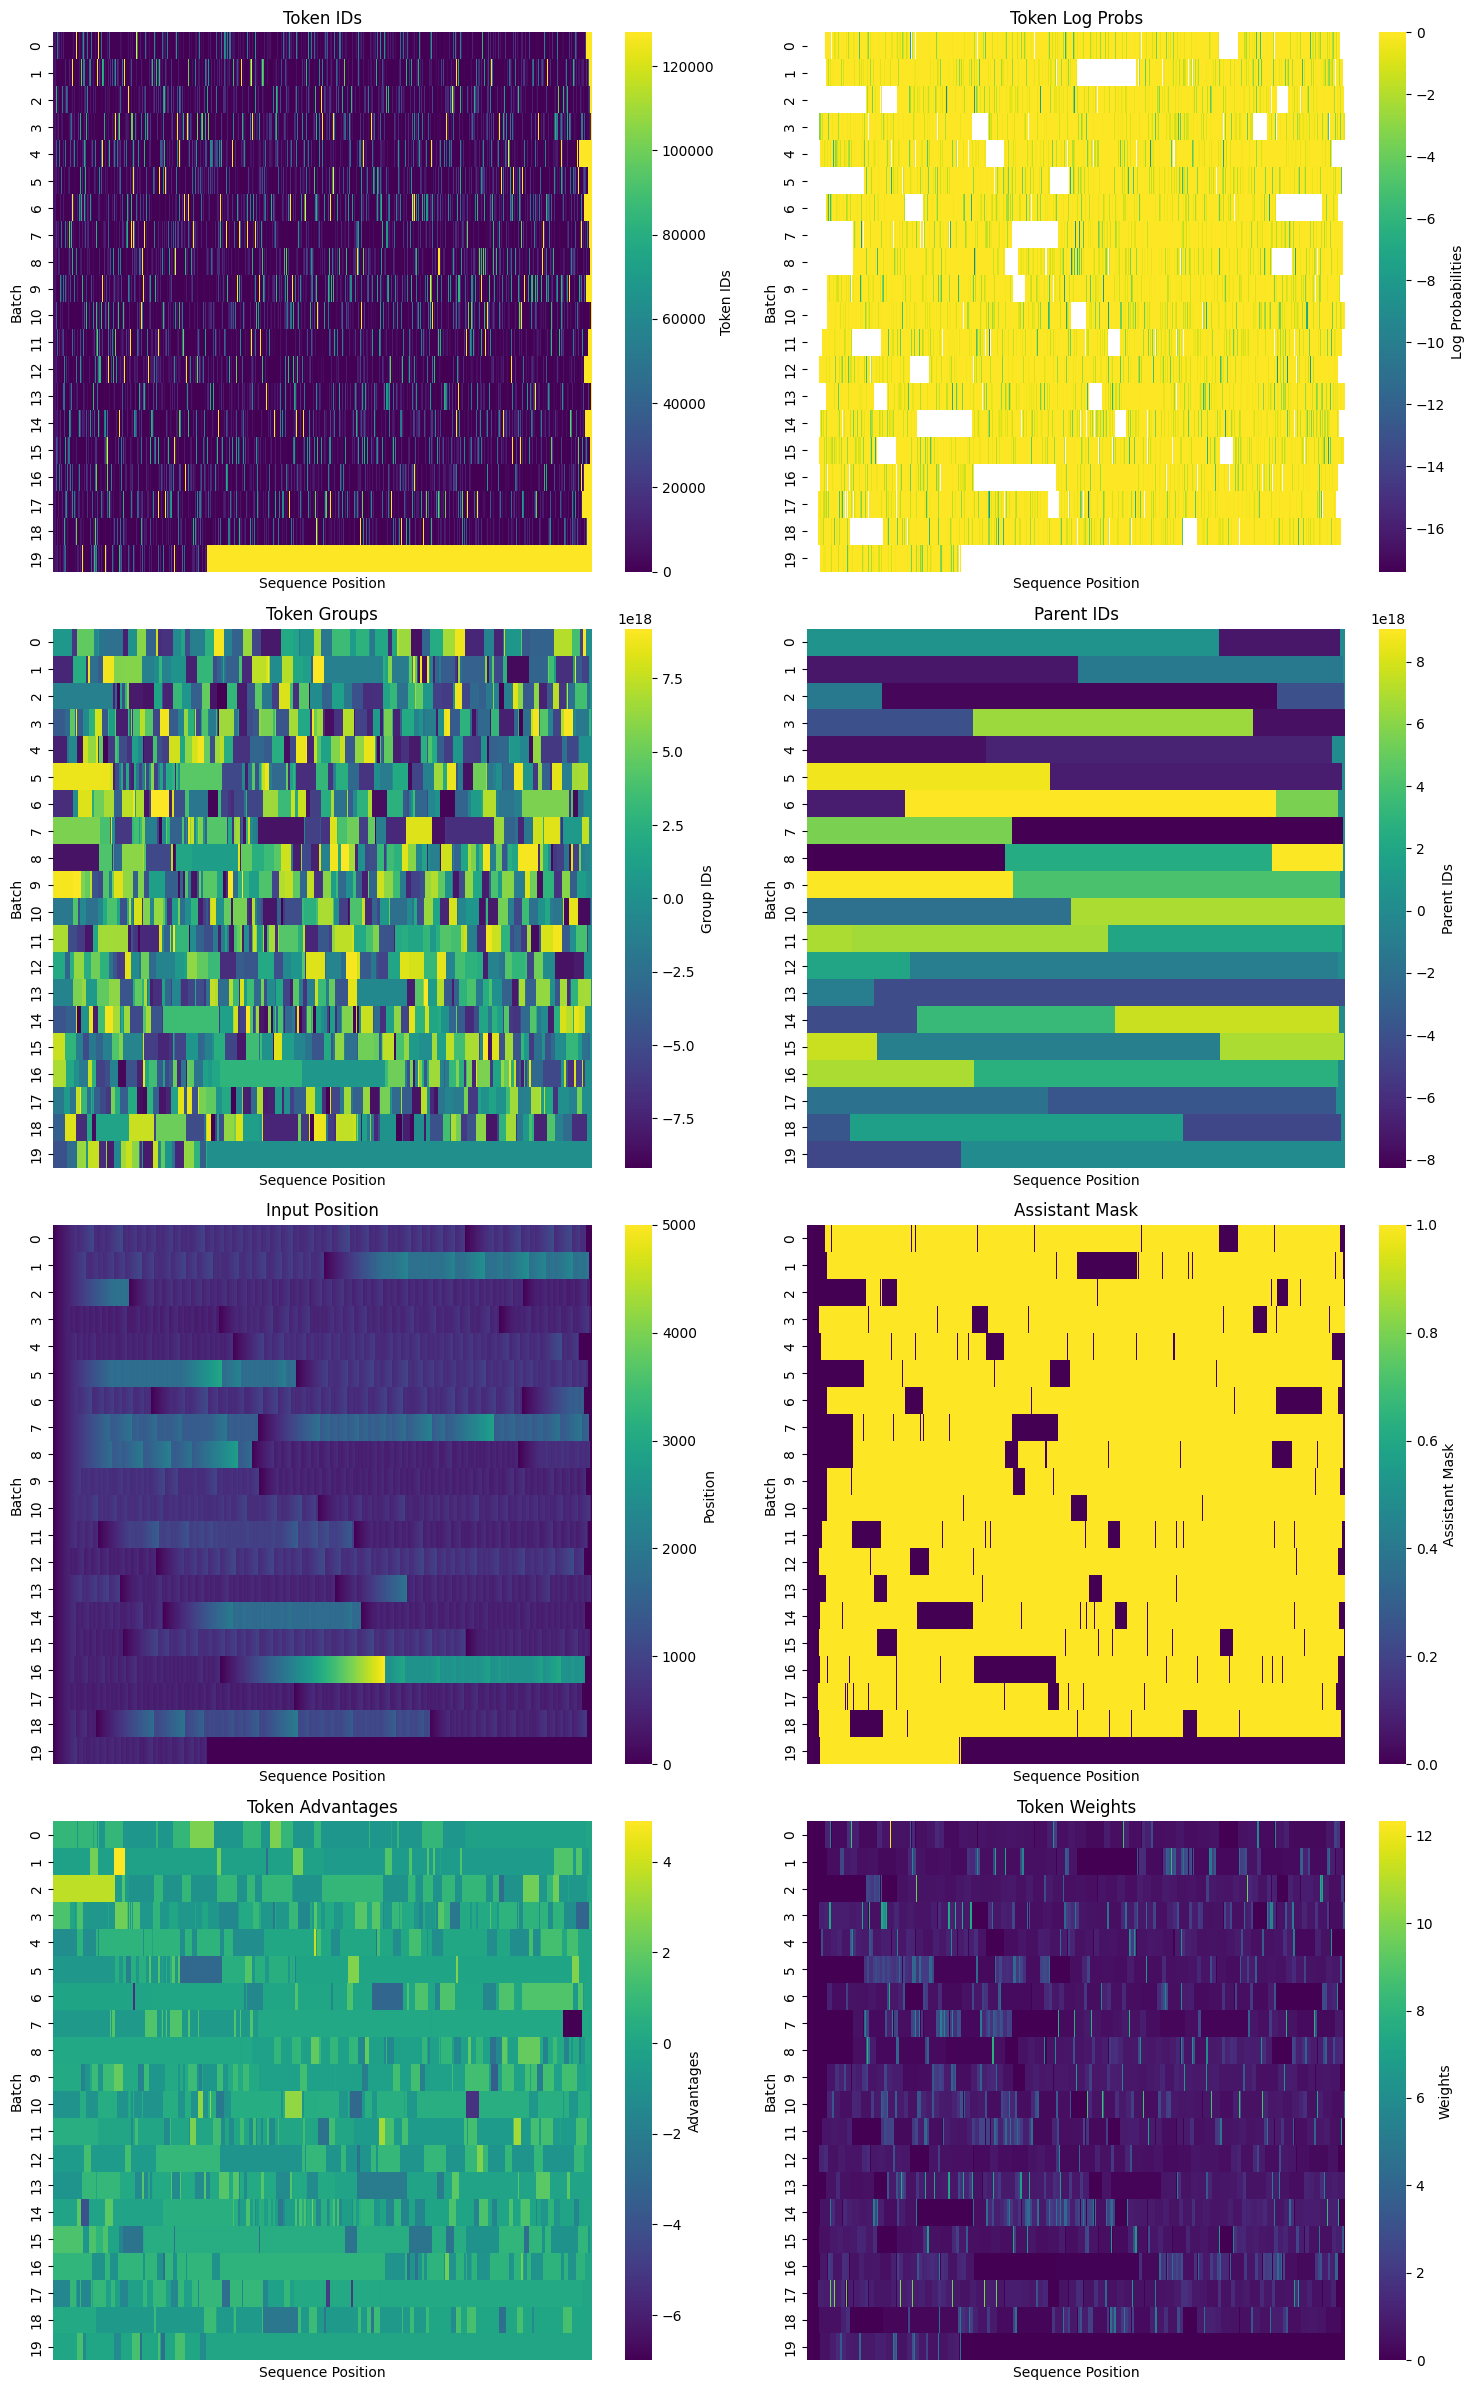

$ tune run art.local.recipe.TuneRecipe --config ./.art/models/temporal-clue-005/config.yaml


<frozen runpy>:128: RuntimeWarning: 'art.local.recipe' found in sys.modules after import of package 'art.local', but prior to execution of 'art.local.recipe'; this may result in unpredictable behaviour
DEBUG:torchtune.utils._logging:Training is not distributed. If you want to train on multiple GPUs and are using the tune CLI, specify --nnodes 1 and --nproc_per_node [num_gpus]
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./.art/models/temporal-clue-005/0002
  checkpoint_files:
  - ft-model-00004-of-00004.safetensors
  - ft-model-00001-of-00004.safetensors
  - ft-model-00003-of-00004.safetensors
  - ft-model-00002-of-00004.safetensors
  model_type: LLAMA3
  output_dir: ./.art/models/temporal-clue-005
  recipe_checkpoint: null
compile: true
custom_sh

Writing logs to .art/models/temporal-clue-005/logs/log_1742227017.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 2.92 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 15.02 GiB
	GPU peak memory reserved: 15.14 GiB
	GPU peak memory active: 15.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|10|Loss: -0.0110: 100%|██████████| 10/10 [03:23<00:00, 19.47s/it, loss=-0.011, policy=-0.011, entropy=0.415, kl_div=nan]    INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict.

$ vllm serve /home/ubuntu/sky_workdir/examples/.art/models/temporal-clue-005/0003 --block-size=32 --disable-log-requests --enable-chunked-prefill --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-num-seqs=2048 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --tool-call-parser=hermes --served-model-name=temporal-clue-005 --port=8000 --api-key=default
INFO 03-17 16:00:59 __init__.py:207] Automatically detected platform cuda.
INFO 03-17 16:00:59 api_server.py:912] vLLM API server version 0.7.3
INFO 03-17 16:00:59 api_server.py:913] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/examples/.art/models/temporal-clue-005/0003', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_temp

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:00,  4.54it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.45it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.15it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.00s/it]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.13it/s]



INFO 03-17 16:01:16 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 03-17 16:01:18 worker.py:267] Memory profiling takes 1.35 seconds
INFO 03-17 16:01:18 worker.py:267] the current vLLM instance can use total_gpu_memory (79.19GiB) x gpu_memory_utilization (0.95) = 75.23GiB
INFO 03-17 16:01:18 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 9.45GiB; the rest of the memory reserved for KV Cache is 50.67GiB.
INFO 03-17 16:01:18 executor_base.py:111] # cuda blocks: 12972, # CPU blocks: 20480
INFO 03-17 16:01:18 executor_base.py:116] Maximum concurrency for 8192 tokens per request: 50.67x
INFO 03-17 16:02:08 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 51.31 seconds
INFO 03-17 16:02:09 api_server.py:958] Starting vLLM API server on http://0.0.0.0:8000
INFO 03-17 16:02:09 launcher.py:23] Available routes are:
INFO 03-17 16:02:09 launcher.py:31] Route: /openapi.json, Methods: GET,

INFO:     Started server process [18010]
INFO:     Waiting for application startup.
INFO:     Application startup complete.


INFO 03-17 16:02:15 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 03-17 16:02:16 metrics.py:455] Avg prompt throughput: 1.5 tokens/s, Avg generation throughput: 0.1 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 03-17 16:02:16 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:41514 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log
Using previous iteration 179.594375 completion tokens per request as estimate


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

Deleted iteration directory ./.art/models/temporal-clue-005/0001


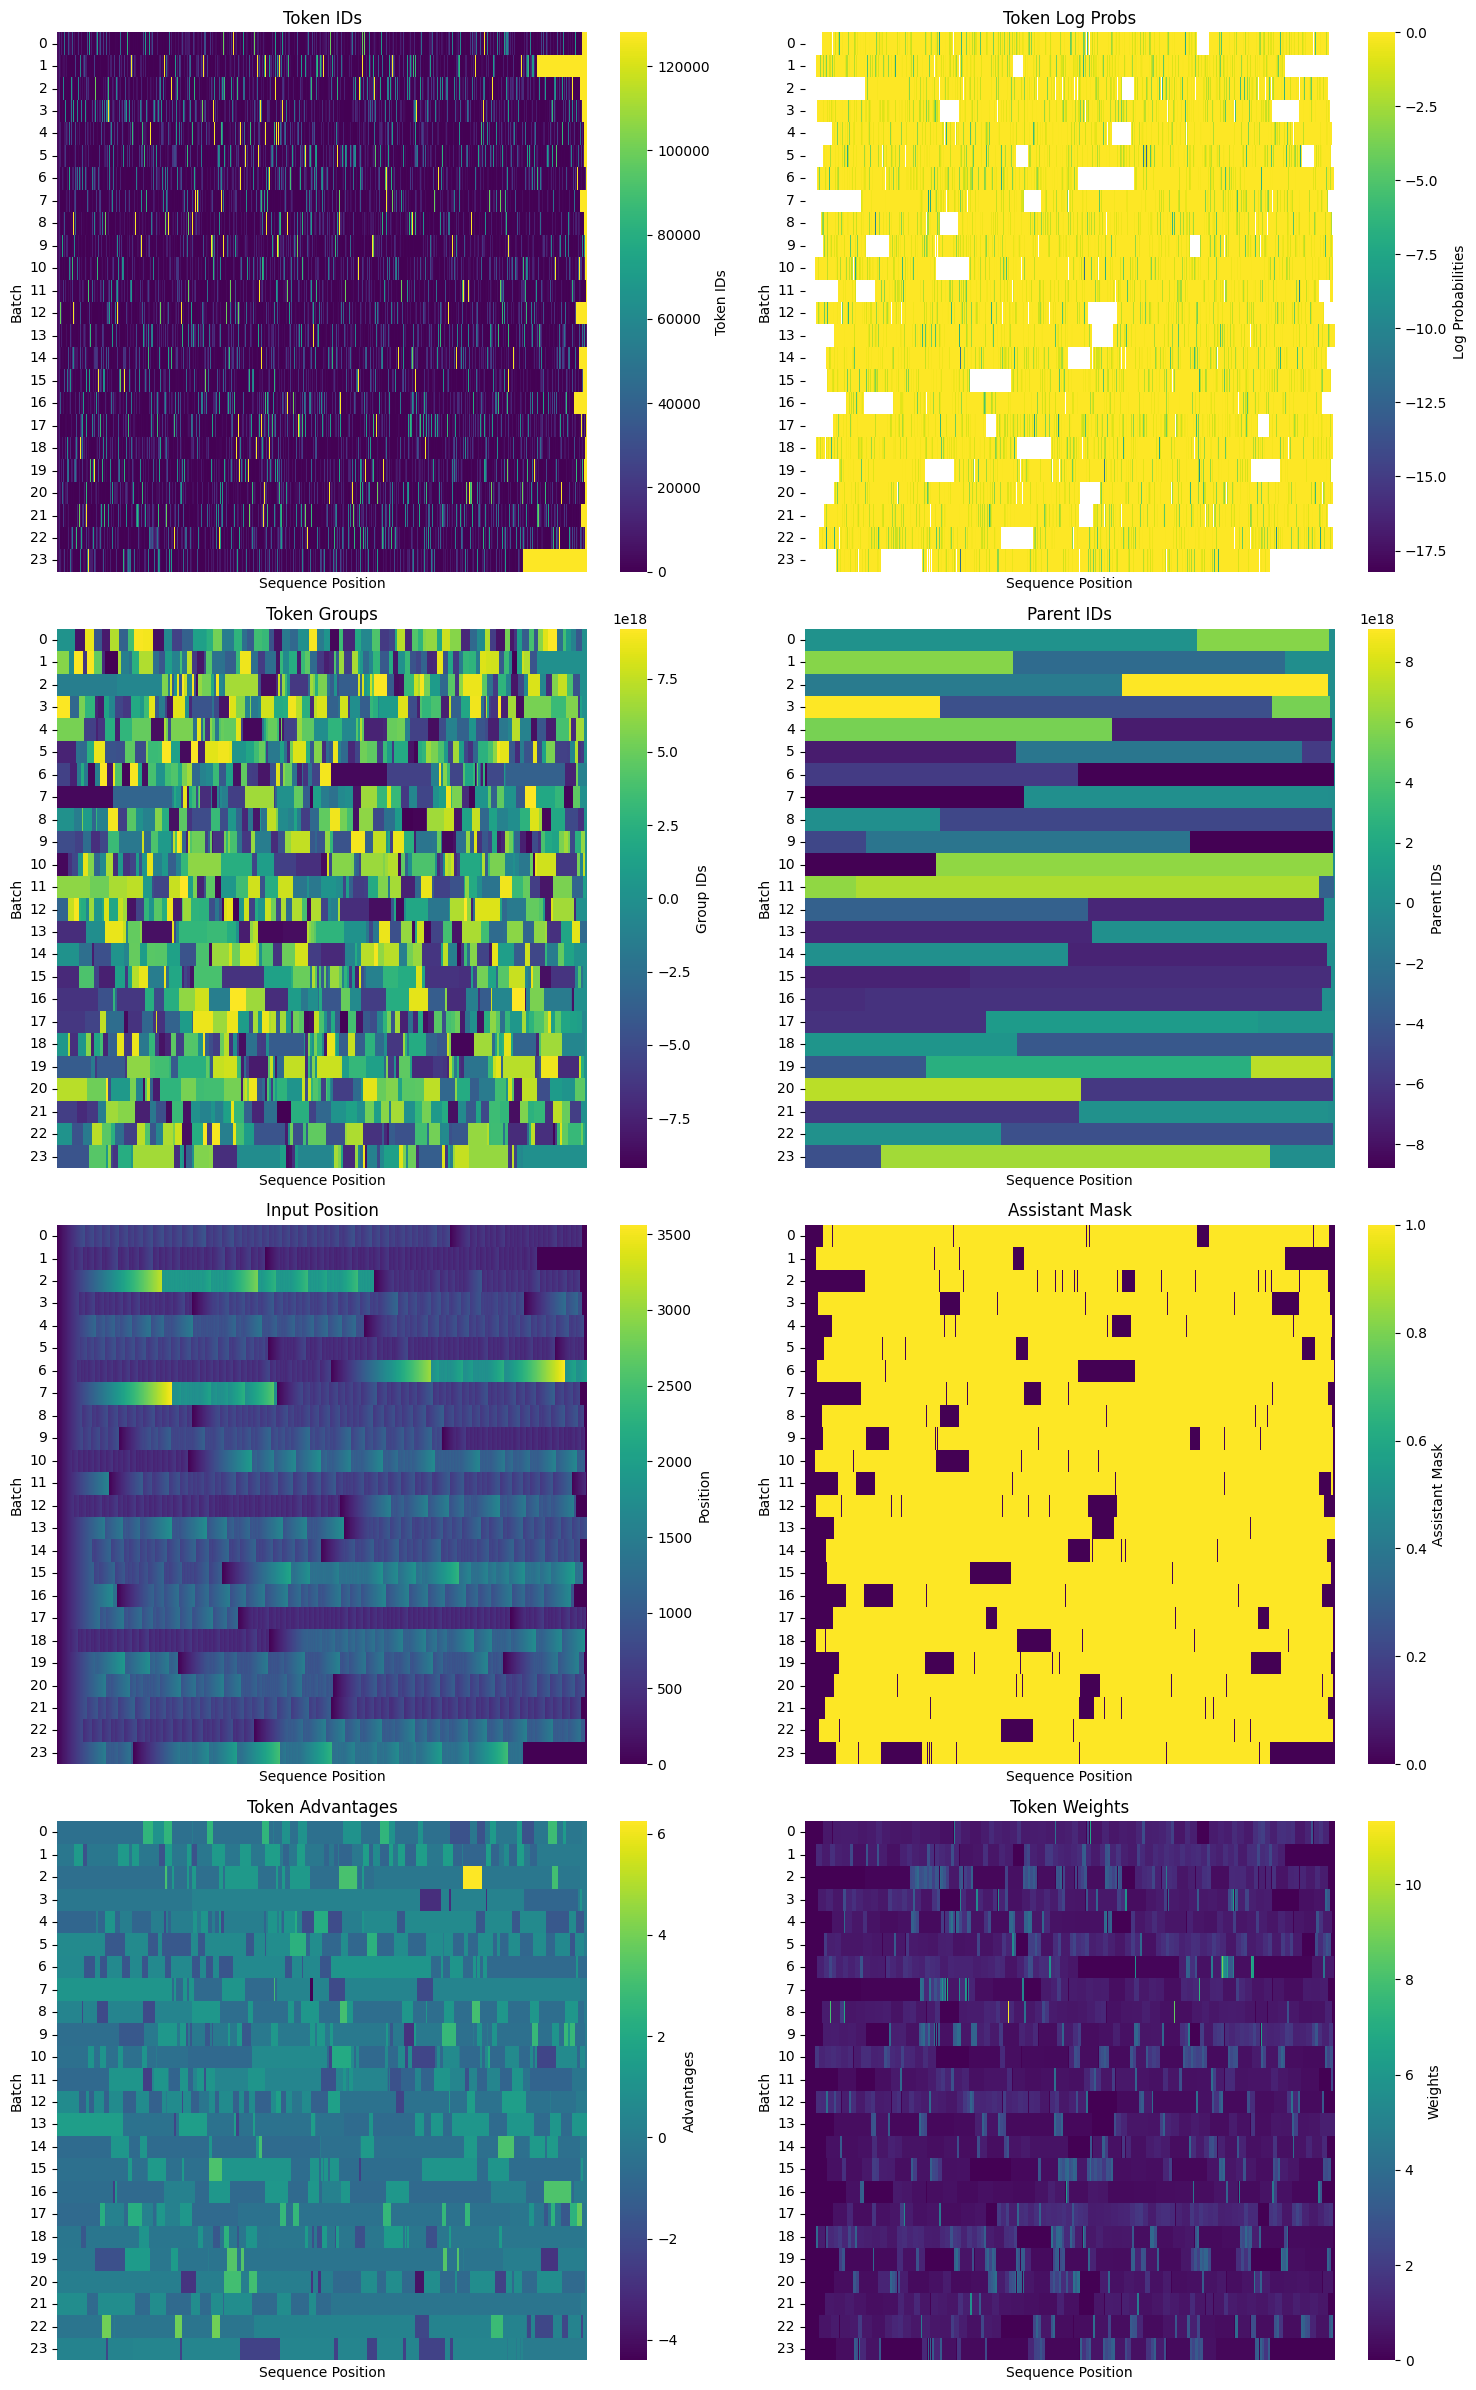

$ tune run art.local.recipe.TuneRecipe --config ./.art/models/temporal-clue-005/config.yaml


<frozen runpy>:128: RuntimeWarning: 'art.local.recipe' found in sys.modules after import of package 'art.local', but prior to execution of 'art.local.recipe'; this may result in unpredictable behaviour
DEBUG:torchtune.utils._logging:Training is not distributed. If you want to train on multiple GPUs and are using the tune CLI, specify --nnodes 1 and --nproc_per_node [num_gpus]
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./.art/models/temporal-clue-005/0003
  checkpoint_files:
  - ft-model-00004-of-00004.safetensors
  - ft-model-00001-of-00004.safetensors
  - ft-model-00003-of-00004.safetensors
  - ft-model-00002-of-00004.safetensors
  model_type: LLAMA3
  output_dir: ./.art/models/temporal-clue-005
  recipe_checkpoint: null
compile: true
custom_sh

Writing logs to .art/models/temporal-clue-005/logs/log_1742227474.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 2.35 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 15.02 GiB
	GPU peak memory reserved: 15.14 GiB
	GPU peak memory active: 15.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|12|Loss: 0.0686: 100%|██████████| 12/12 [03:59<00:00, 19.42s/it, loss=0.0686, policy=0.0686, entropy=0.296, kl_div=nan]   INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...

$ vllm serve /home/ubuntu/sky_workdir/examples/.art/models/temporal-clue-005/0004 --block-size=32 --disable-log-requests --enable-chunked-prefill --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-num-seqs=2048 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --tool-call-parser=hermes --served-model-name=temporal-clue-005 --port=8000 --api-key=default
INFO 03-17 16:09:11 __init__.py:207] Automatically detected platform cuda.
INFO 03-17 16:09:11 api_server.py:912] vLLM API server version 0.7.3
INFO 03-17 16:09:11 api_server.py:913] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/examples/.art/models/temporal-clue-005/0004', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_temp

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:00,  4.79it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.58it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.25it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.12it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.26it/s]



INFO 03-17 16:09:25 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 03-17 16:09:27 worker.py:267] Memory profiling takes 1.29 seconds
INFO 03-17 16:09:27 worker.py:267] the current vLLM instance can use total_gpu_memory (79.19GiB) x gpu_memory_utilization (0.95) = 75.23GiB
INFO 03-17 16:09:27 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 9.45GiB; the rest of the memory reserved for KV Cache is 50.67GiB.
INFO 03-17 16:09:27 executor_base.py:111] # cuda blocks: 12972, # CPU blocks: 20480
INFO 03-17 16:09:27 executor_base.py:116] Maximum concurrency for 8192 tokens per request: 50.67x
INFO 03-17 16:10:18 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 52.60 seconds
INFO 03-17 16:10:19 api_server.py:958] Starting vLLM API server on http://0.0.0.0:8000
INFO 03-17 16:10:19 launcher.py:23] Available routes are:
INFO 03-17 16:10:19 launcher.py:31] Route: /openapi.json, Methods: HEAD

INFO:     Started server process [21697]
INFO:     Waiting for application startup.
INFO:     Application startup complete.


INFO 03-17 16:10:24 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 03-17 16:10:24 metrics.py:455] Avg prompt throughput: 1.7 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 03-17 16:10:24 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:45304 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log
Using previous iteration 223.25125 completion tokens per request as estimate


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

Deleted iteration directory ./.art/models/temporal-clue-005/0003


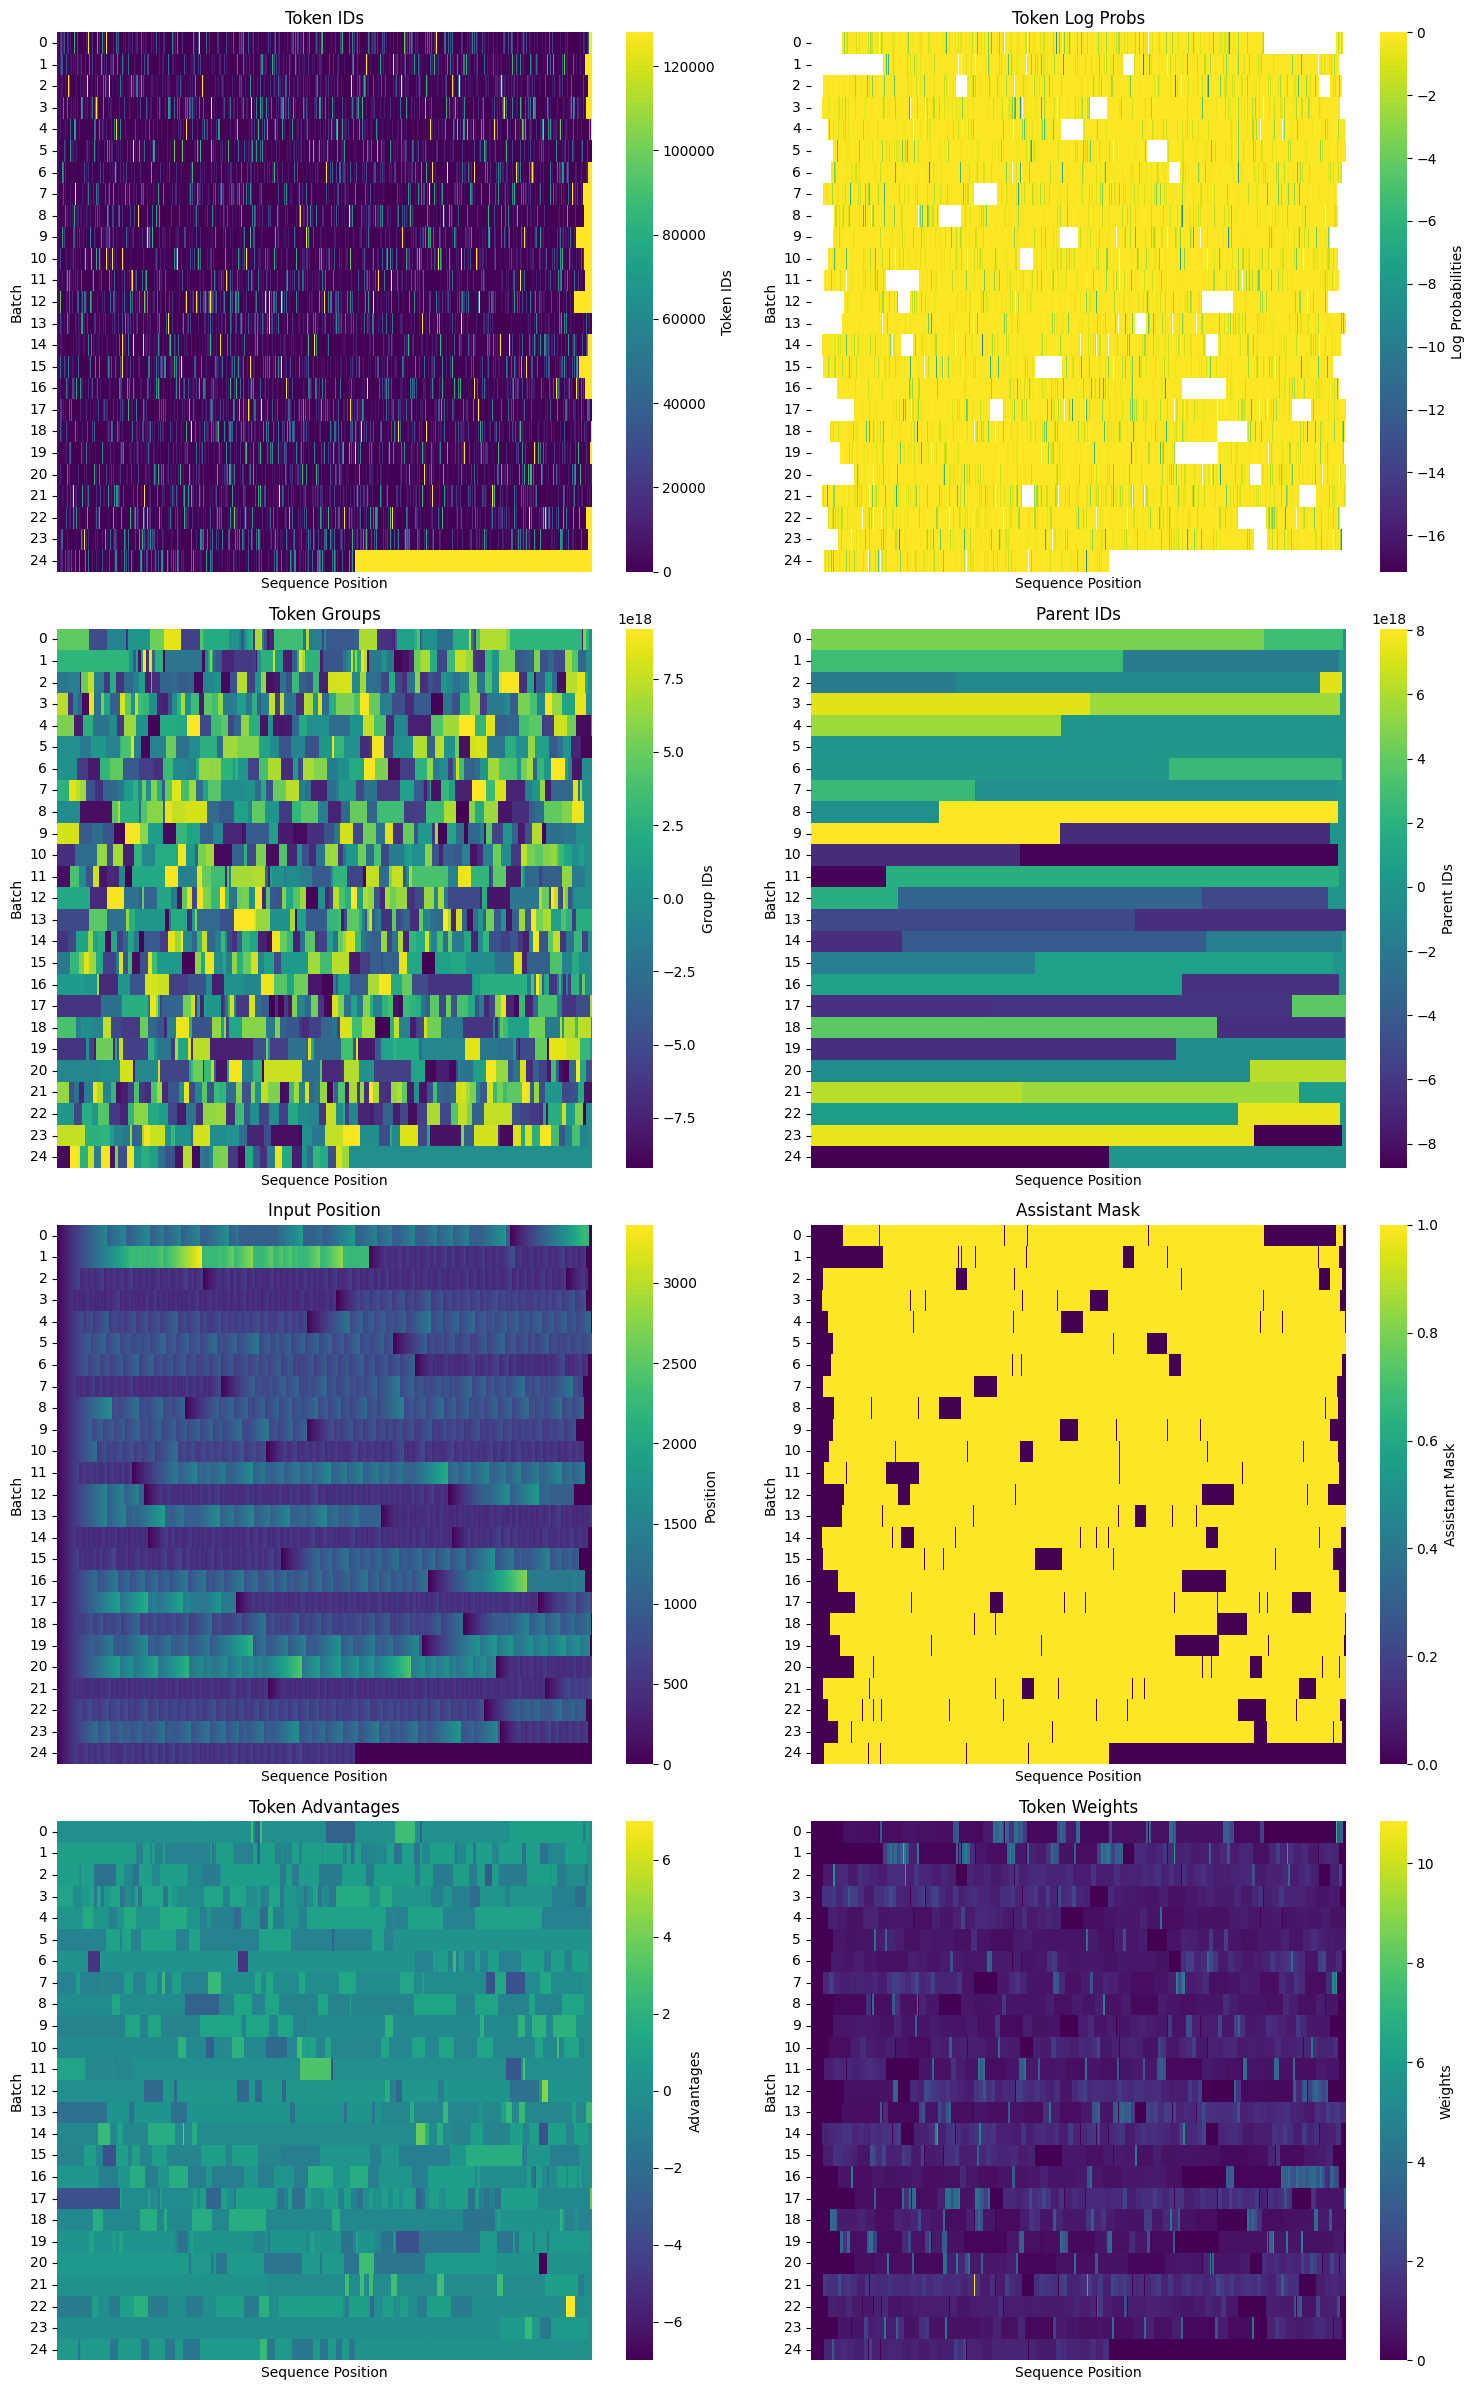

$ tune run art.local.recipe.TuneRecipe --config ./.art/models/temporal-clue-005/config.yaml


<frozen runpy>:128: RuntimeWarning: 'art.local.recipe' found in sys.modules after import of package 'art.local', but prior to execution of 'art.local.recipe'; this may result in unpredictable behaviour
DEBUG:torchtune.utils._logging:Training is not distributed. If you want to train on multiple GPUs and are using the tune CLI, specify --nnodes 1 and --nproc_per_node [num_gpus]
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./.art/models/temporal-clue-005/0004
  checkpoint_files:
  - ft-model-00004-of-00004.safetensors
  - ft-model-00001-of-00004.safetensors
  - ft-model-00003-of-00004.safetensors
  - ft-model-00002-of-00004.safetensors
  model_type: LLAMA3
  output_dir: ./.art/models/temporal-clue-005
  recipe_checkpoint: null
compile: true
custom_sh

Writing logs to .art/models/temporal-clue-005/logs/log_1742228014.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 2.29 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 15.02 GiB
	GPU peak memory reserved: 15.14 GiB
	GPU peak memory active: 15.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|12|Loss: 0.0594: 100%|██████████| 12/12 [03:59<00:00, 19.41s/it, loss=0.0594, policy=0.0594, entropy=0.404, kl_div=nan]   INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...

$ vllm serve /home/ubuntu/sky_workdir/examples/.art/models/temporal-clue-005/0005 --block-size=32 --disable-log-requests --enable-chunked-prefill --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-num-seqs=2048 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --tool-call-parser=hermes --served-model-name=temporal-clue-005 --port=8000 --api-key=default
INFO 03-17 16:18:10 __init__.py:207] Automatically detected platform cuda.
INFO 03-17 16:18:10 api_server.py:912] vLLM API server version 0.7.3
INFO 03-17 16:18:10 api_server.py:913] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/examples/.art/models/temporal-clue-005/0005', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_temp

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:00,  4.71it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.60it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.28it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.17it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.30it/s]



INFO 03-17 16:18:27 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 03-17 16:18:28 worker.py:267] Memory profiling takes 1.26 seconds
INFO 03-17 16:18:28 worker.py:267] the current vLLM instance can use total_gpu_memory (79.19GiB) x gpu_memory_utilization (0.95) = 75.23GiB
INFO 03-17 16:18:28 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 9.45GiB; the rest of the memory reserved for KV Cache is 50.67GiB.
INFO 03-17 16:18:28 executor_base.py:111] # cuda blocks: 12972, # CPU blocks: 20480
INFO 03-17 16:18:28 executor_base.py:116] Maximum concurrency for 8192 tokens per request: 50.67x
INFO 03-17 16:19:19 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 51.78 seconds
INFO 03-17 16:19:20 api_server.py:958] Starting vLLM API server on http://0.0.0.0:8000
INFO 03-17 16:19:20 launcher.py:23] Available routes are:
INFO 03-17 16:19:20 launcher.py:31] Route: /openapi.json, Methods: GET,

INFO:     Started server process [25652]
INFO:     Waiting for application startup.
INFO:     Application startup complete.


INFO 03-17 16:19:26 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 03-17 16:19:27 metrics.py:455] Avg prompt throughput: 1.4 tokens/s, Avg generation throughput: 0.1 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 03-17 16:19:27 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:56948 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log
Using previous iteration 246.25625 completion tokens per request as estimate


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

Deleted iteration directory ./.art/models/temporal-clue-005/0002


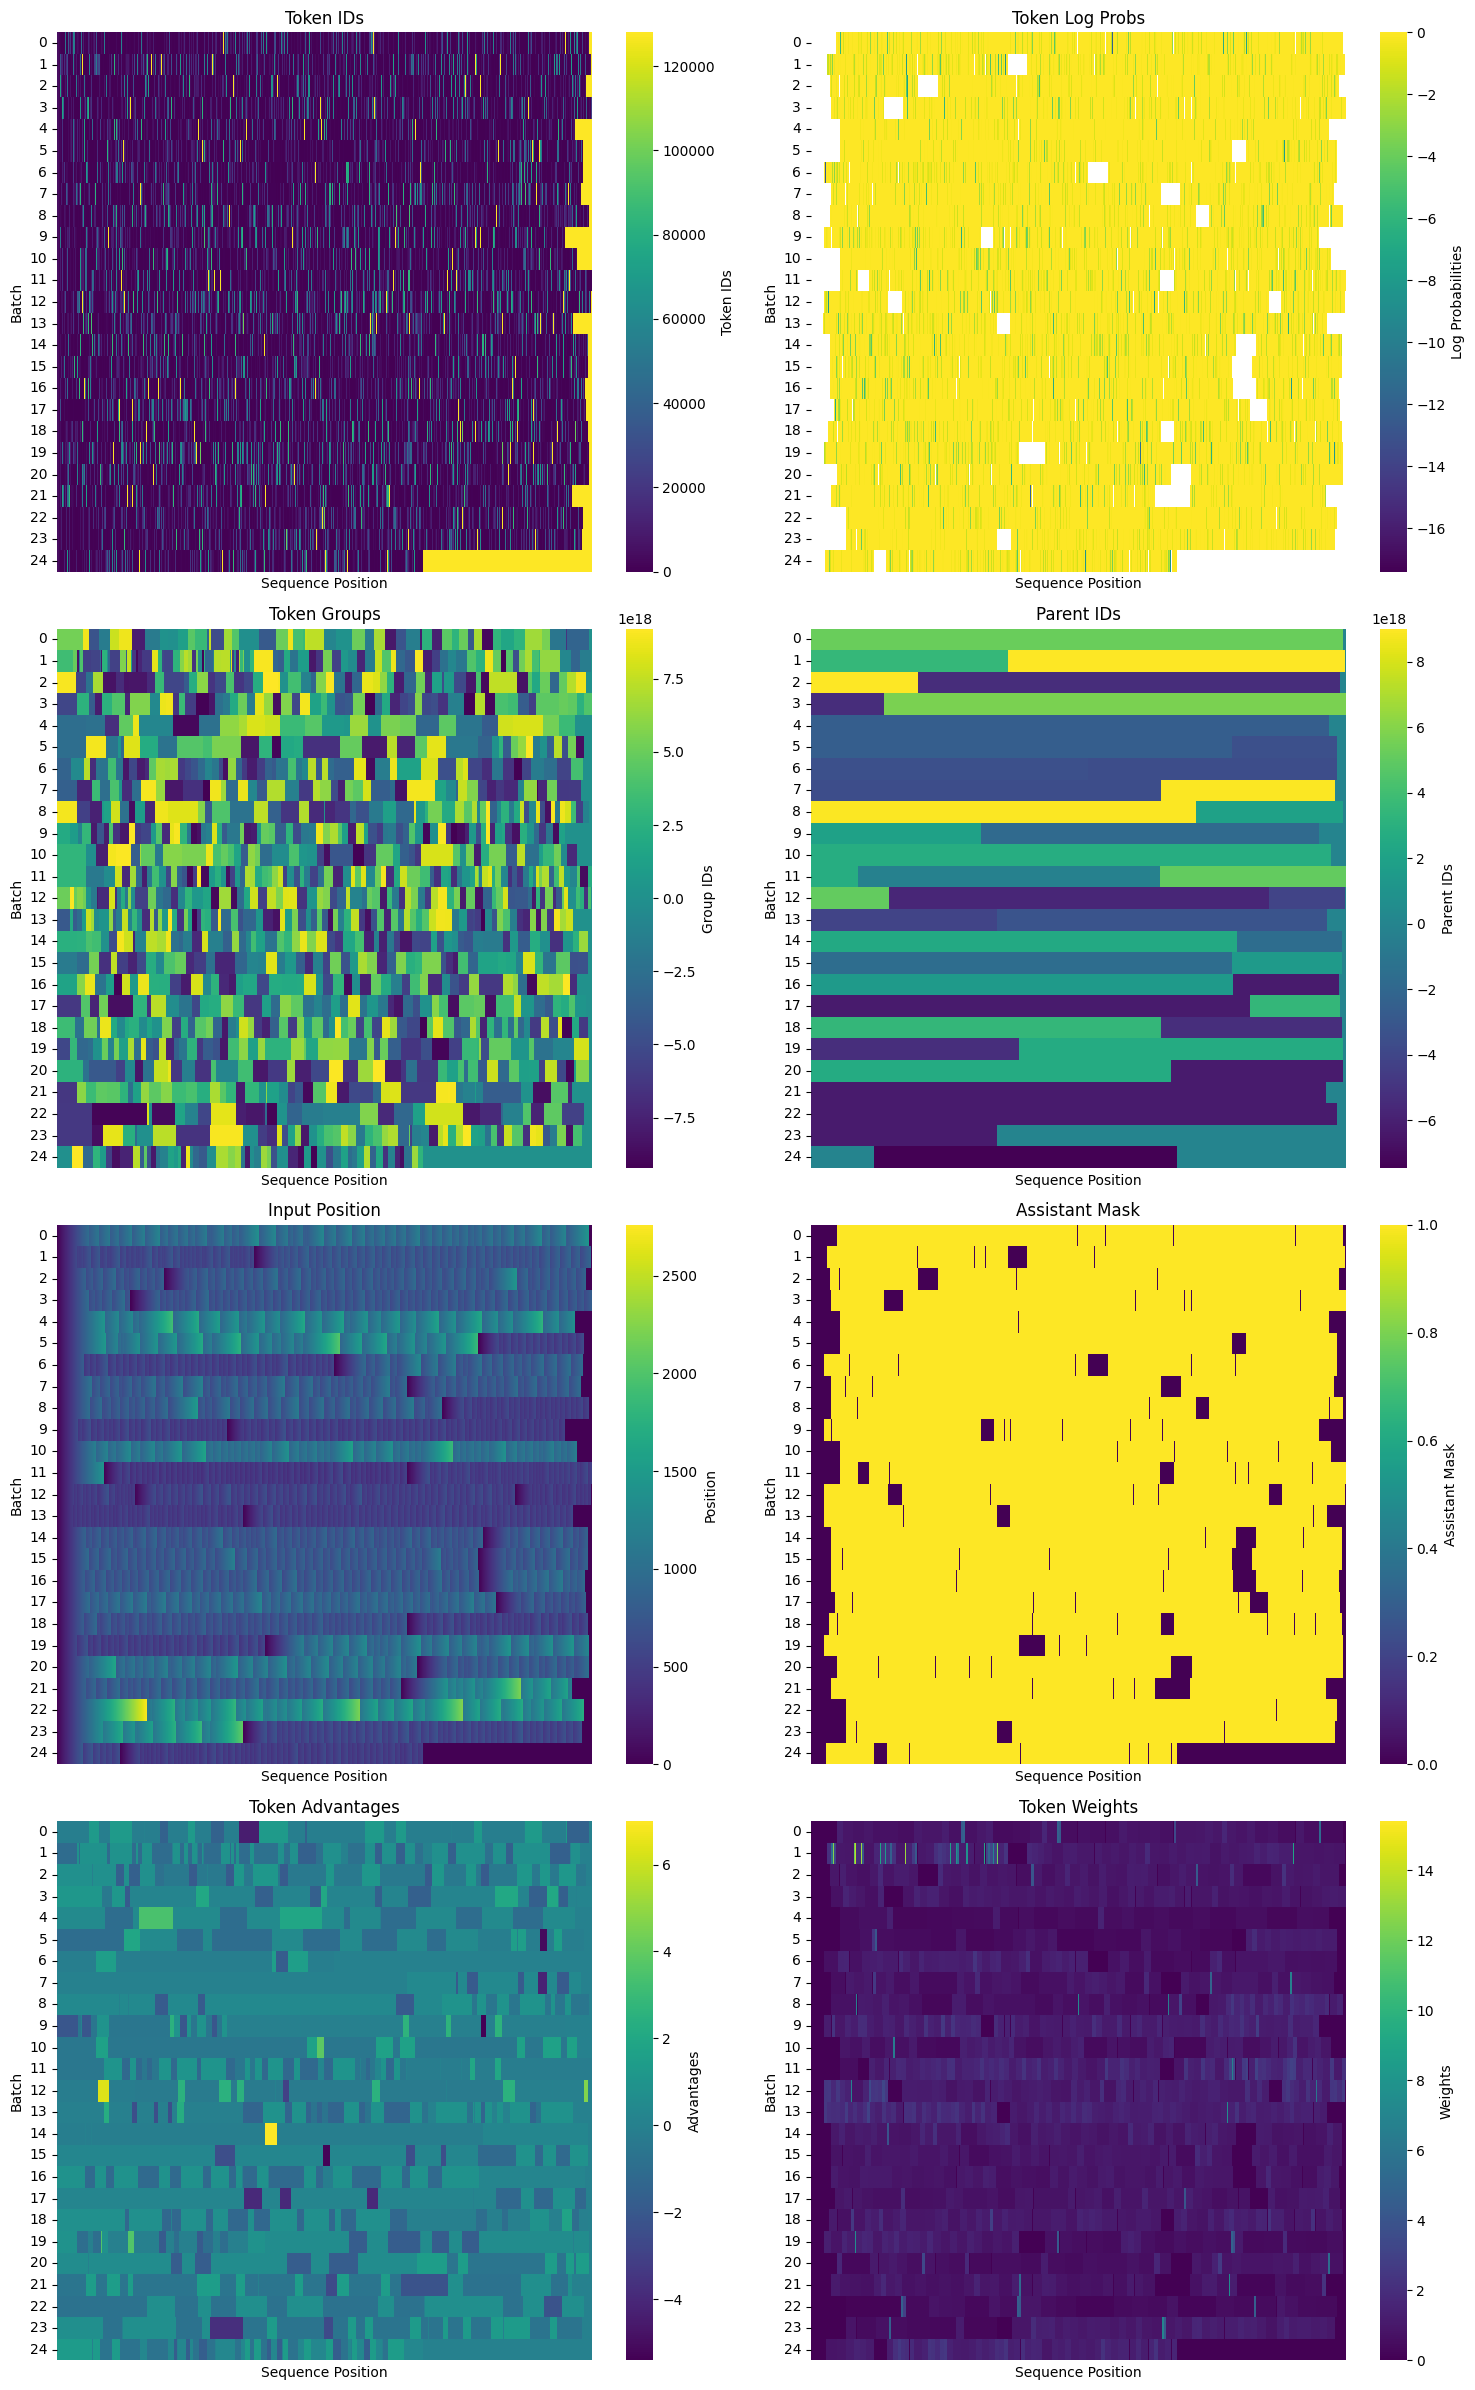

$ tune run art.local.recipe.TuneRecipe --config ./.art/models/temporal-clue-005/config.yaml


<frozen runpy>:128: RuntimeWarning: 'art.local.recipe' found in sys.modules after import of package 'art.local', but prior to execution of 'art.local.recipe'; this may result in unpredictable behaviour
DEBUG:torchtune.utils._logging:Training is not distributed. If you want to train on multiple GPUs and are using the tune CLI, specify --nnodes 1 and --nproc_per_node [num_gpus]
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./.art/models/temporal-clue-005/0005
  checkpoint_files:
  - ft-model-00004-of-00004.safetensors
  - ft-model-00001-of-00004.safetensors
  - ft-model-00003-of-00004.safetensors
  - ft-model-00002-of-00004.safetensors
  model_type: LLAMA3
  output_dir: ./.art/models/temporal-clue-005
  recipe_checkpoint: null
compile: true
custom_sh

Writing logs to .art/models/temporal-clue-005/logs/log_1742228559.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 2.36 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 15.02 GiB
	GPU peak memory reserved: 15.14 GiB
	GPU peak memory active: 15.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|1|Loss: -0.0241:   8%|▊         | 1/12 [00:26<04:48, 26.21s/it, loss=-0.0241, policy=-0.0241, entropy=0.316, kl_div=nan]

In [ ]:
api = art.LocalAPI(wandb_project="agent-reinforcement-training")
model = await api.get_or_create_model(
    name="temporal-clue-005", base_model="NousResearch/Hermes-2-Theta-Llama-3-8B"
)


async def rollout(
    client: openai.AsyncOpenAI, puzzle: TemporalCluePuzzle
) -> art.Trajectory:
    messages: art.Messages = [{"role": "user", "content": puzzle["prompt"]}]
    chat_completion = await client.chat.completions.create(
        messages=messages, model=model.name
    )
    choice = chat_completion.choices[0]
    content = choice.message.content
    assert isinstance(content, str)
    num_correct = 0
    for key, value in puzzle["solution"].items():
        if matches := re.findall(rf"{key}\. ([A-Za-z \.:-]+)", content):
            match = matches[-1]
            if match.strip().lower() == value.lower():
                num_correct += 1
    reward = acc = num_correct / len(puzzle["solution"])
    return art.Trajectory(
        messages_and_choices=[*messages, choice], reward=reward, metrics={"acc": acc}
    )


stride = 32
for i in range(await model.get_iteration(), len(curriculum_train_puzzles) // stride):
    async with model.openai_client(
        estimated_completion_tokens=350, verbosity=2
    ) as openai_client:
        val_groups, train_groups = await asyncio.gather(
            art.gather_groups(
                (
                    (rollout(openai_client, puzzle) for _ in range(2))
                    for puzzle in val_puzzles
                ),
                pbar_desc="val",
                stream_chat_completions=8,
            ),
            art.gather_groups(
                (
                    (rollout(openai_client, puzzle) for _ in range(50))
                    for puzzle in curriculum_train_puzzles[
                        i * stride : (i + 1) * stride
                    ]
                ),
                pbar_desc="train",
            ),
        )
    await model.save(val_groups)
    await model.clear_iterations()
    await model.tune(
        train_groups, config=art.TuneConfig(plot_tensors=True, verbosity=2)
    )

async with model.openai_client(
    estimated_completion_tokens=350, verbosity=2
) as openai_client:
    # Final evaluation
    val_groups, test_groups = await asyncio.gather(
        art.gather_groups(
            (rollout(openai_client, puzzle) for _ in range(4)) for puzzle in val_puzzles
        ),
        art.gather_groups(
            (rollout(openai_client, puzzle) for _ in range(4))
            for puzzle in test_puzzles
        ),
    )
await model.save(val_groups)
await model.save(test_groups)
await model.clear_iterations()